In [1]:
# --- Load the previously merged panel dataset ---

import pandas as pd

panel = pd.read_csv("sustainability-economic-performance/data/processed/panel_full_unfiltered.csv")

# display the first 10 rows
panel.head(10)

,Country Name,Country Code,Indicator,Year,Value,Category,Source,Region,Income Group
0,Afghanistan,AFG,Research and development expenditure (% of GDP),2000,NaN,Economic,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
1,Afghanistan,AFG,GDP growth (annual %),2000,NaN,Economic,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
2,Afghanistan,AFG,GDP per capita (constant 2015 US$),2000,308.318270,Economic,Economic,"Middle East, North Africa, Afghanistan & Pakistan",Low income
3,Afghanistan,AFG,"Inflation, consumer prices (annual %)",2000,NaN,Economic,Economic,"Middle East, North Africa, Afghanistan & Pakistan",Low income
4,Afghanistan,AFG,"Foreign direct investment, net inflows (% of GDP)",2000,0.004828,Economic,Economic,"Middle East, North Africa, Afghanistan & Pakistan",Low income
5,Afghanistan,AFG,CO2 emissions (metric tons per capita),2000,0.053557,Environmental,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
6,Afghanistan,AFG,Fossil fuel energy consumption (% of total),2000,NaN,Environmental,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
7,Afghanistan,AFG,Renewable energy consumption (% of total final...,2000,45.000000,Environmental,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
8,Afghanistan,AFG,Renewable electricity output (% of total elect...,2000,93.537318,Environmental,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income
9,Afghanistan,AFG,Nitrous oxide emissions (metric tons of CO2 eq...,2000,0.172754,Environmental,ESG,"Middle East, North Africa, Afghanistan & Pakistan",Low income


In [2]:
# how big is this panel ?
panel.shape, panel.columns

((74112, 9),
 Index(['Country Name', 'Country Code', 'Indicator', 'Year', 'Value',
        'Category', 'Source', 'Region', 'Income Group'],
       dtype='object'))

In [3]:
# --- Create a table showing the distribution of all 192 countries ---

# keep only one row per country
countries_unique = panel[["Country Name", "Region", "Income Group"]].drop_duplicates()

# create the Region × Income Group table
region_income_table = pd.crosstab(
    countries_unique["Region"],
    countries_unique["Income Group"],
    margins = True,
    margins_name = "Total"
)

# remove axis labels so "Region" and "Income Group" don't appear inside the table
region_income_table.index.name = None
region_income_table.columns.name = None

# add a grey background to the total rows and columns
def highlight_total_row(row):
    if row.name == "Total":
        return ['font-weight: bold; background-color: #f0f0f0'] * len(row)
    else:
        return [''] * len(row)

def highlight_total_col(col):
    if col.name == "Total":
        return ['font-weight: bold; background-color: #f0f0f0'] * len(col)
    else:
        return [''] * len(col)

# build a nicer styled table
styled_192_table = (
    region_income_table
    .style
    .set_table_styles([
        # whole table border behavior
        {
            "selector": "table",
            "props": [
                ("border-collapse", "collapse"),
                ("border", "1px solid #aaaaaa")
            ],
        },
        # header cells (top row: income groups)
        {
            "selector": "th.col_heading",
            "props": [
                ("background-color", "#f5f5f5"),
                ("font-weight", "bold"),
                ("border", "1px solid #aaaaaa"),
                ("padding", "6px"),
                ("text-align", "center")
            ],
        },
        # row labels (left side: regions + Total)
        {
            "selector": "th.row_heading",
            "props": [
                ("background-color", "#f5f5f5"),
                ("font-weight", "bold"),
                ("border", "1px solid #aaaaaa"),
                ("padding", "6px"),
                ("text-align", "left")
            ],
        },
        # corner cell (top-left)
        {
            "selector": "th.blank",
            "props": [
                ("background-color", "#f5f5f5"),
                ("border", "1px solid #aaaaaa")
            ],
        },
        # data cells
        {
            "selector": "td",
            "props": [
                ("border", "1px solid #cccccc"),
                ("padding", "6px"),
                ("text-align", "center")
            ],
        },
    ])
    .apply(highlight_total_row, axis=1)  # style Total row
    .apply(highlight_total_col, axis=0)  # style Total column
)

styled_192_table

,High income,Low income,Lower middle income,Upper middle income,Total
East Asia & Pacific,8,1,11,10,30
Europe & Central Asia,35,0,3,14,52
Latin America & Caribbean,10,0,4,18,32
"Middle East, North Africa, Afghanistan & Pakistan",8,3,7,4,22
North America,2,0,0,0,2
South Asia,0,0,5,1,6
Sub-Saharan Africa,1,22,19,6,48
Total,64,26,49,53,192


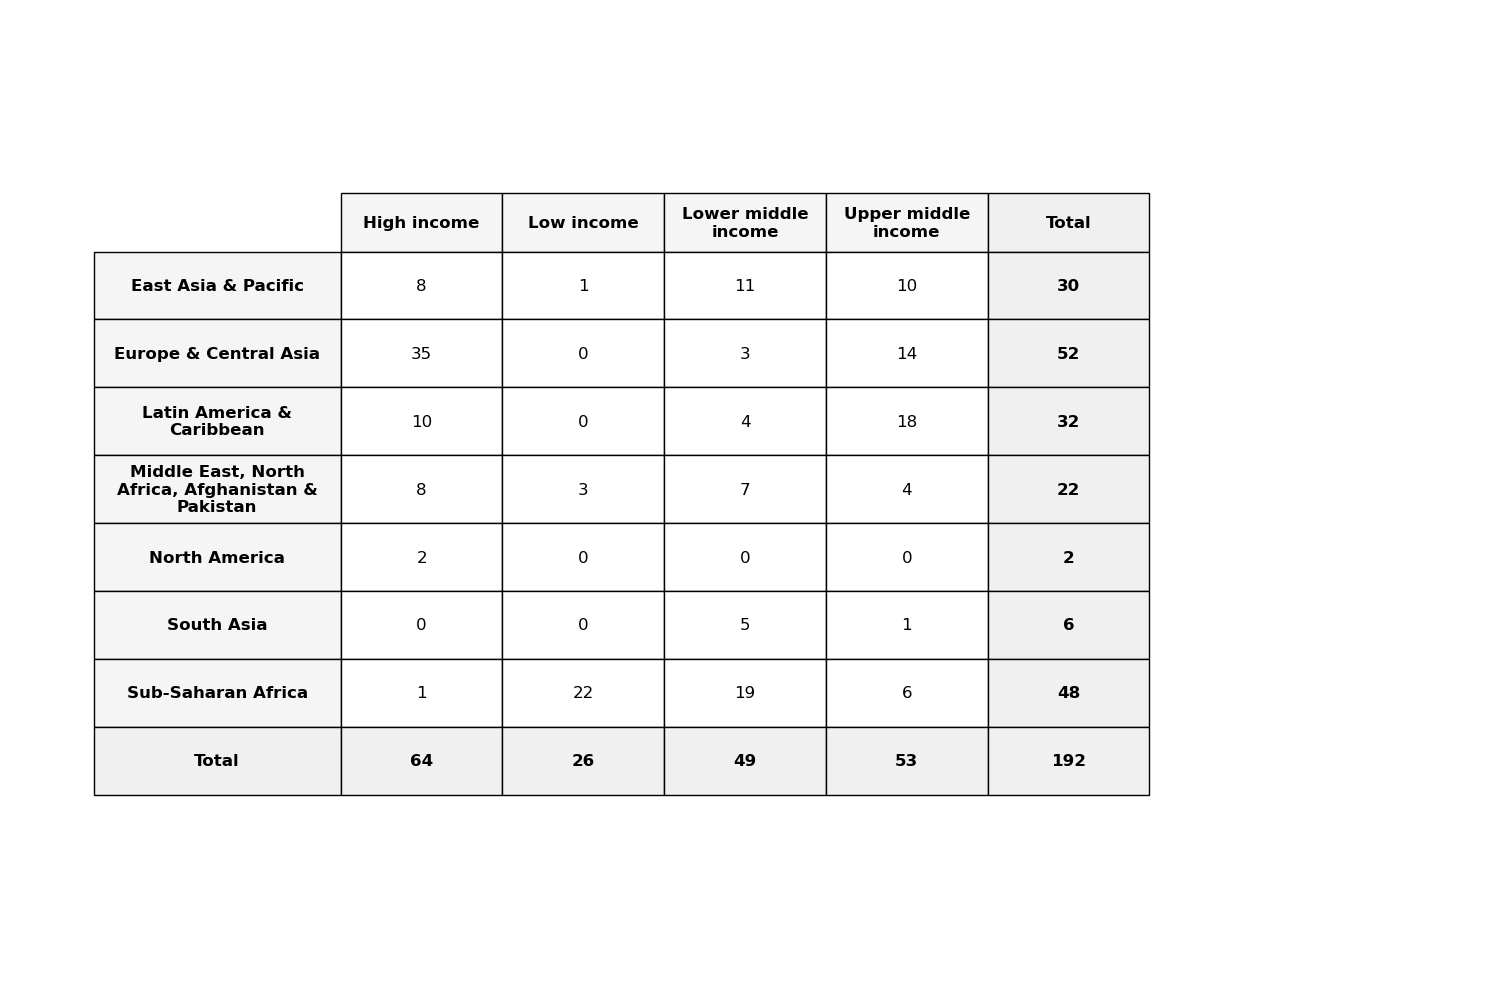

'sustainability-economic-performance/results/country_distribution/region_income_table_192.pdf'

In [4]:
# --- Use matplotlib to convert this table to a pdf ---

import matplotlib.pyplot as plt
import textwrap

df = region_income_table.copy()
n_rows, n_cols = df.shape

# --- Wrap long labels ---

def wrap_text(text, width):
    """Insert line breaks every `width` characters (on nearest space)."""
    return "\n".join(textwrap.wrap(str(text), width=width))

# Wrap long region names (row index)
wrapped_index = [wrap_text(idx, width=23) for idx in df.index]

# Wrap long column headers (income groups)
wrapped_columns = [wrap_text(col, width=12) for col in df.columns]

# create the figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis("off")

# build the table
tbl = ax.table(
    cellText=df.values,
    rowLabels=wrapped_index,      # regions + "Total"
    colLabels=wrapped_columns,    # income groups + "Total"
    cellLoc="center",
    rowLoc="center",
    loc="center",
    colWidths=[0.11] + [0.11] * (n_cols - 1),  # first col + others
)

# adjust cell heights
for (row, col), cell in tbl.get_celld().items():
    if row == 0:        # header row
        cell.set_height(0.06)
    else:               # body rows
        cell.set_height(0.07)

# 3. font size
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

# 4. style cells
for (row, col), cell in tbl.get_celld().items():
    # borders
    cell.set_edgecolor("black")
    cell.set_linewidth(1)

    # header row (income groups)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f5f5f5")

    # row labels (regions + "Total") live in column -1 in matplotlib's table
    if col == -1:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f5f5f5")

    # total column OR Total row in bold + light grey
    if col == n_cols - 1 or row == n_rows:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f0f0f0")

plt.tight_layout()

# save to PDF under results/country_distribution
output_path = "sustainability-economic-performance/results/country_distribution/region_income_table_192.pdf"
plt.savefig(output_path, bbox_inches="tight")
plt.show()

output_path

In [5]:
# --- Compute data availability per country ---

# create a table showing how many entries there is per country, and what percentage of these entries are non-missing
country_stats = (
    panel
    .groupby(["Country Name", "Country Code", "Region", "Income Group"])
    .agg(
        total_points=("Value", "size"),
        non_missing=("Value", lambda x: x.notna().sum())
    )
    .reset_index()
)

country_stats["share_non_missing"] = (
    country_stats["non_missing"] / country_stats["total_points"]
)

# rename the columns to clearer names
country_stats = country_stats.rename(columns={
    "total_points": "Total Values",
    "non_missing": "Non Missing",
    "share_non_missing": "% of non-missing"
})

# display all 192 countries
country_stats.head(192)

,Country Name,Country Code,Region,Income Group,Total Values,Non Missing,% of non-missing
0,Afghanistan,AFG,"Middle East, North Africa, Afghanistan & Pakistan",Low income,384,277,0.721354
1,Albania,ALB,Europe & Central Asia,Upper middle income,384,302,0.786458
2,Algeria,DZA,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income,384,309,0.804688
3,Andorra,AND,Europe & Central Asia,High income,384,207,0.539062
4,Angola,AGO,Sub-Saharan Africa,Lower middle income,384,309,0.804688
...,...,...,...,...,...,...,...
187,Vanuatu,VUT,East Asia & Pacific,Lower middle income,384,292,0.760417
188,Viet Nam,VNM,East Asia & Pacific,Lower middle income,384,323,0.841146
189,"Yemen, Rep.",YEM,"Middle East, North Africa, Afghanistan & Pakistan",Low income,384,263,0.684896
190,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,384,299,0.778646


In [6]:
# take a look at the overall distribution of the panel
country_stats["% of non-missing"].describe()

count    192.000000
mean       0.804316
std        0.111177
min        0.208333
25%        0.747396
50%        0.813802
75%        0.893229
max        0.927083
Name: % of non-missing, dtype: float64

In [7]:
# sort the dataset by data availability
country_stats_sorted = country_stats.sort_values(
    "% of non-missing", ascending=False
)

# display the 50 countries with the most data available
country_stats_sorted.head(50)

,Country Name,Country Code,Region,Income Group,Total Values,Non Missing,% of non-missing
184,United States,USA,North America,High income,384,356,0.927083
55,Estonia,EST,Europe & Central Asia,High income,384,355,0.924479
73,Hungary,HUN,Europe & Central Asia,High income,384,355,0.924479
59,France,FRA,Europe & Central Asia,High income,384,355,0.924479
99,Lithuania,LTU,Europe & Central Asia,High income,384,355,0.924479
137,Poland,POL,Europe & Central Asia,High income,384,355,0.924479
31,Canada,CAN,North America,High income,384,354,0.921875
81,Italy,ITA,Europe & Central Asia,High income,384,354,0.921875
79,Ireland,IRL,Europe & Central Asia,High income,384,354,0.921875
93,Latvia,LVA,Europe & Central Asia,High income,384,353,0.919271


In [8]:
# filter only South Asia
south_asia = country_stats[country_stats["Region"] == "South Asia"].copy()

# select only the columns we want to display
south_asia_table = south_asia[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort countries by data availability (highest first)
south_asia_table = south_asia_table.sort_values("% of non-missing", ascending=False)

south_asia_table

,Country Name,Country Code,Income Group,% of non-missing
75,India,IND,Lower middle income,0.867188
160,Sri Lanka,LKA,Lower middle income,0.822917
121,Nepal,NPL,Lower middle income,0.794271
13,Bangladesh,BGD,Lower middle income,0.786458
104,Maldives,MDV,Upper middle income,0.765625
19,Bhutan,BTN,Lower middle income,0.726562


In [9]:
# filter only North America
north_america = country_stats[country_stats["Region"] == "North America"].copy()

# select columns to display
north_america_table = north_america[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
north_america_table = north_america_table.sort_values("% of non-missing", ascending=False)

north_america_table

,Country Name,Country Code,Income Group,% of non-missing
184,United States,USA,High income,0.927083
31,Canada,CAN,High income,0.921875


In [10]:
# filter only "Middle East, North Africa, Afghanistan & Pakistan"
mena_region = country_stats[
    country_stats["Region"] == "Middle East, North Africa, Afghanistan & Pakistan"
].copy()

# select columns to display
mena_table = mena_region[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
mena_table = mena_table.sort_values("% of non-missing", ascending=False)

mena_table

,Country Name,Country Code,Income Group,% of non-missing
80,Israel,ISR,High income,0.919271
106,Malta,MLT,High income,0.885417
77,"Iran, Islamic Rep.",IRN,Upper middle income,0.867188
51,"Egypt, Arab Rep.",EGY,Lower middle income,0.848958
176,Tunisia,TUN,Lower middle income,0.846354
146,Saudi Arabia,SAU,High income,0.841146
90,Kuwait,KWT,High income,0.833333
130,Pakistan,PAK,Lower middle income,0.833333
129,Oman,OMN,High income,0.830729
2,Algeria,DZA,Upper middle income,0.804688


In [11]:
# filter only Latin America & Caribbean
lac_region = country_stats[
    country_stats["Region"] == "Latin America & Caribbean"
].copy()

# select columns to display
lac_table = lac_region[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
lac_table = lac_table.sort_values("% of non-missing", ascending=False)

lac_table

,Country Name,Country Code,Income Group,% of non-missing
23,Brazil,BRA,Upper middle income,0.916667
36,Colombia,COL,Upper middle income,0.916667
40,Costa Rica,CRI,High income,0.914062
132,Panama,PAN,High income,0.911458
110,Mexico,MEX,Upper middle income,0.901042
185,Uruguay,URY,High income,0.901042
50,Ecuador,ECU,Upper middle income,0.890625
135,Peru,PER,Upper middle income,0.880208
52,El Salvador,SLV,Upper middle income,0.877604
6,Argentina,ARG,Upper middle income,0.875000


In [12]:
# filter only East Asia & Pacific
eap_region = country_stats[
    country_stats["Region"] == "East Asia & Pacific"
].copy()

# select columns to display
eap_table = eap_region[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
eap_table = eap_table.sort_values("% of non-missing", ascending=False)

eap_table

,Country Name,Country Code,Income Group,% of non-missing
35,China,CHN,Upper middle income,0.901042
83,Japan,JPN,High income,0.898438
89,"Korea, Rep.",KOR,High income,0.893229
76,Indonesia,IDN,Upper middle income,0.888021
171,Thailand,THA,Upper middle income,0.882812
114,Mongolia,MNG,Upper middle income,0.867188
8,Australia,AUS,High income,0.856771
103,Malaysia,MYS,Upper middle income,0.856771
188,Viet Nam,VNM,Lower middle income,0.841146
151,Singapore,SGP,High income,0.841146


In [13]:
# filter only Sub-Saharan Africa
ssa_region = country_stats[
    country_stats["Region"] == "Sub-Saharan Africa"
].copy()

# select columns to display
ssa_table = ssa_region[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
ssa_table = ssa_table.sort_values("% of non-missing", ascending=False)

ssa_table

,Country Name,Country Code,Income Group,% of non-missing
157,South Africa,ZAF,Upper middle income,0.869792
101,Madagascar,MDG,Low income,0.851562
109,Mauritius,MUS,Upper middle income,0.843750
147,Senegal,SEN,Lower middle income,0.820312
26,Burkina Faso,BFA,Low income,0.817708
41,Cote d'Ivoire,CIV,Lower middle income,0.817708
164,Sudan,SDN,Low income,0.817708
64,Ghana,GHA,Lower middle income,0.815104
117,Mozambique,MOZ,Low income,0.812500
142,Rwanda,RWA,Low income,0.812500


In [14]:
# filter only Europe & Centra Asia
eca_region = country_stats[
    country_stats["Region"] == "Europe & Central Asia"
].copy()

# select columns to display
eca_table = eca_region[[
    "Country Name",
    "Country Code",
    "Income Group",
    "% of non-missing"
]]

# sort by data availability (highest first)
eca_table = eca_table.sort_values("% of non-missing", ascending=False)

eca_table

,Country Name,Country Code,Income Group,% of non-missing
73,Hungary,HUN,High income,0.924479
55,Estonia,EST,High income,0.924479
59,France,FRA,High income,0.924479
99,Lithuania,LTU,High income,0.924479
137,Poland,POL,High income,0.924479
81,Italy,ITA,High income,0.921875
79,Ireland,IRL,High income,0.921875
16,Belgium,BEL,High income,0.919271
46,Denmark,DNK,High income,0.919271
58,Finland,FIN,High income,0.919271


In [15]:
# --- list of the 50 selected countries ---

selected_countries = [
    # North America
    "United States", "Canada",
    
    # South Asia
    "India", "Sri Lanka", "Nepal", "Bangladesh", "Maldives", "Bhutan",
    
    # MENA + Afghanistan & Pakistan
    "Israel", "Iran, Islamic Rep.", "Egypt, Arab Rep.", "Tunisia",
    "Saudi Arabia", "Pakistan", "Algeria",
    
    # Latin America & Caribbean
    "Brazil", "Colombia", "Mexico", "Costa Rica", "Uruguay", "Chile",
    "Honduras", "Bolivia", "Dominican Republic", "Peru",
    
    # East Asia & Pacific
    "Japan", "Korea, Rep.", "Australia", "China", "Indonesia",
    "Viet Nam", "Philippines", "Cambodia",
    
    # Sub-Saharan Africa
    "South Africa", "Mauritius", "Nigeria", "Ghana", "Kenya",
    "Madagascar", "Rwanda", "Burkina Faso",
    
    # Europe & Central Asia
    "Germany", "France", "United Kingdom", "Poland", "Romania",
    "Hungary", "Georgia", "Kazakhstan", "Uzbekistan"
]

panel_50 = panel[panel["Country Name"].isin(selected_countries)].copy()
panel_50["Country Name"].nunique()

50

In [16]:
# --- Table of the 50 chosen countries ---
countries_df = pd.DataFrame({"Country Name": selected_countries})

info_df = (
    countries_df
    .merge(
        panel[["Country Name", "Country Code", "Region", "Income Group"]].drop_duplicates(),
        on="Country Name",
        how="left"
    )
    .sort_values("Country Name")   # alphabetical sorting
    .reset_index(drop=True)
)

# make index start at 1 instead of 0
info_df.index = info_df.index + 1

# display final table
info_df

,Country Name,Country Code,Region,Income Group
1,Algeria,DZA,"Middle East, North Africa, Afghanistan & Pakistan",Upper middle income
2,Australia,AUS,East Asia & Pacific,High income
3,Bangladesh,BGD,South Asia,Lower middle income
4,Bhutan,BTN,South Asia,Lower middle income
5,Bolivia,BOL,Latin America & Caribbean,Lower middle income
6,Brazil,BRA,Latin America & Caribbean,Upper middle income
7,Burkina Faso,BFA,Sub-Saharan Africa,Low income
8,Cambodia,KHM,East Asia & Pacific,Lower middle income
9,Canada,CAN,North America,High income
10,Chile,CHL,Latin America & Caribbean,High income


In [17]:
# split the table in two parts
df_part1 = info_df.iloc[:25].copy()
df_part2 = info_df.iloc[25:].copy()

df_part1.index = df_part1.index
df_part2.index = df_part2.index

In [18]:
# --- Use matplotlib to convert this table to a pdf ---

import matplotlib.pyplot as plt
import textwrap

def export_table_to_pdf(df, pdf_path, 
                        col_widths=None,
                        wrap_index=15,
                        wrap_cols=14,
                        figsize=(14, 12),
                        fontsize=11):

    # Copy data
    table = df.copy()
    n_rows, n_cols = table.shape

    # Wrap text
    def wrap_text(text, width):
        return "\n".join(textwrap.wrap(str(text), width=width))
    
    wrapped_index = [wrap_text(idx, wrap_index) for idx in table.index]
    wrapped_columns = [wrap_text(col, wrap_cols) for col in table.columns]

    # Default: equal width if not provided
    if col_widths is None:
        col_widths = [1 / n_cols] * n_cols

    # Build figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    tbl = ax.table(
        cellText=table.values,
        rowLabels=wrapped_index,
        colLabels=wrapped_columns,
        cellLoc="center",
        rowLoc="center",
        loc="center",
        colWidths=col_widths,
    )

    # Row heights
    for (row, col), cell in tbl.get_celld().items():
        if row == 0:
            cell.set_height(0.05)
        else:
            cell.set_height(0.06)

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(fontsize)

    # Style cells
    for (row, col), cell in tbl.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1)
        if row == 0:
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f5f5f5")

    plt.savefig(pdf_path, bbox_inches="tight")
    plt.close(fig)

    return pdf_path

export_table_to_pdf(
    df_part1,
    "sustainability-economic-performance/results/country_distribution/table_50_countries_part1.pdf",
    col_widths= [0.15, 0.13, 0.37, 0.20]
)

export_table_to_pdf(
    df_part2,
    "sustainability-economic-performance/results/country_distribution/table_50_countries_part2.pdf",
    col_widths= [0.15, 0.13, 0.37, 0.20]
)

'sustainability-economic-performance/results/country_distribution/table_50_countries_part2.pdf'

In [19]:
# display of the first five rows of the new dataset
panel_50.head()

,Country Name,Country Code,Indicator,Year,Value,Category,Source,Region,Income Group
3072,Australia,AUS,Research and development expenditure (% of GDP),2000,1.571980,Economic,ESG,East Asia & Pacific,High income
3073,Australia,AUS,GDP growth (annual %),2000,3.921503,Economic,ESG,East Asia & Pacific,High income
3074,Australia,AUS,GDP per capita (constant 2015 US$),2000,45859.516210,Economic,Economic,East Asia & Pacific,High income
3075,Australia,AUS,"Inflation, consumer prices (annual %)",2000,4.457435,Economic,Economic,East Asia & Pacific,High income
3076,Australia,AUS,"Foreign direct investment, net inflows (% of GDP)",2000,3.578599,Economic,Economic,East Asia & Pacific,High income


In [20]:
# what is the size of this new panel ?
panel_50.shape

(19200, 9)

In [21]:
# --- Create a table showing the distribution of the sample of 50 countries ---

# extract country info (one row per country)
country_info = panel_50[["Country Name", "Region", "Income Group"]].drop_duplicates()

# crosstab: Region × Income Group with totals
region_income_50_table = pd.crosstab(
    country_info["Region"],
    country_info["Income Group"],
    margins=True,
    margins_name="Total"
)

# remove axis labels so "Region" and "Income Group" don't appear inside the table
region_income_50_table.index.name = None
region_income_50_table.columns.name = None

# styling helpers for Total row & Total column
def highlight_total_row(row):
    if row.name == "Total":
        return ['font-weight: bold; background-color: #f0f0f0'] * len(row)
    else:
        return [''] * len(row)

def highlight_total_col(col):
    if col.name == "Total":
        return ['font-weight: bold; background-color: #f0f0f0'] * len(col)
    else:
        return [''] * len(col)

# build a nicer styled table
styled_50_table = (
    region_income_50_table
    .style
    .set_table_styles([
        # whole table border behavior
        {
            "selector": "table",
            "props": [
                ("border-collapse", "collapse"),
                ("border", "1px solid #aaaaaa")
            ],
        },
        # header cells (top row: income groups)
        {
            "selector": "th.col_heading",
            "props": [
                ("background-color", "#f5f5f5"),
                ("font-weight", "bold"),
                ("border", "1px solid #aaaaaa"),
                ("padding", "6px"),
                ("text-align", "center")
            ],
        },
        # row labels (left side: regions + Total)
        {
            "selector": "th.row_heading",
            "props": [
                ("background-color", "#f5f5f5"),
                ("font-weight", "bold"),
                ("border", "1px solid #aaaaaa"),
                ("padding", "6px"),
                ("text-align", "left")
            ],
        },
        # corner cell (top-left)
        {
            "selector": "th.blank",
            "props": [
                ("background-color", "#f5f5f5"),
                ("border", "1px solid #aaaaaa")
            ],
        },
        # data cells
        {
            "selector": "td",
            "props": [
                ("border", "1px solid #cccccc"),
                ("padding", "6px"),
                ("text-align", "center")
            ],
        },
    ])
    .apply(highlight_total_row, axis=1)  # style Total row
    .apply(highlight_total_col, axis=0)  # style Total column
)

styled_50_table

,High income,Low income,Lower middle income,Upper middle income,Total
East Asia & Pacific,3,0,3,2,8
Europe & Central Asia,6,0,1,2,9
Latin America & Caribbean,3,0,2,5,10
"Middle East, North Africa, Afghanistan & Pakistan",2,0,3,2,7
North America,2,0,0,0,2
South Asia,0,0,5,1,6
Sub-Saharan Africa,0,3,3,2,8
Total,16,3,17,14,50


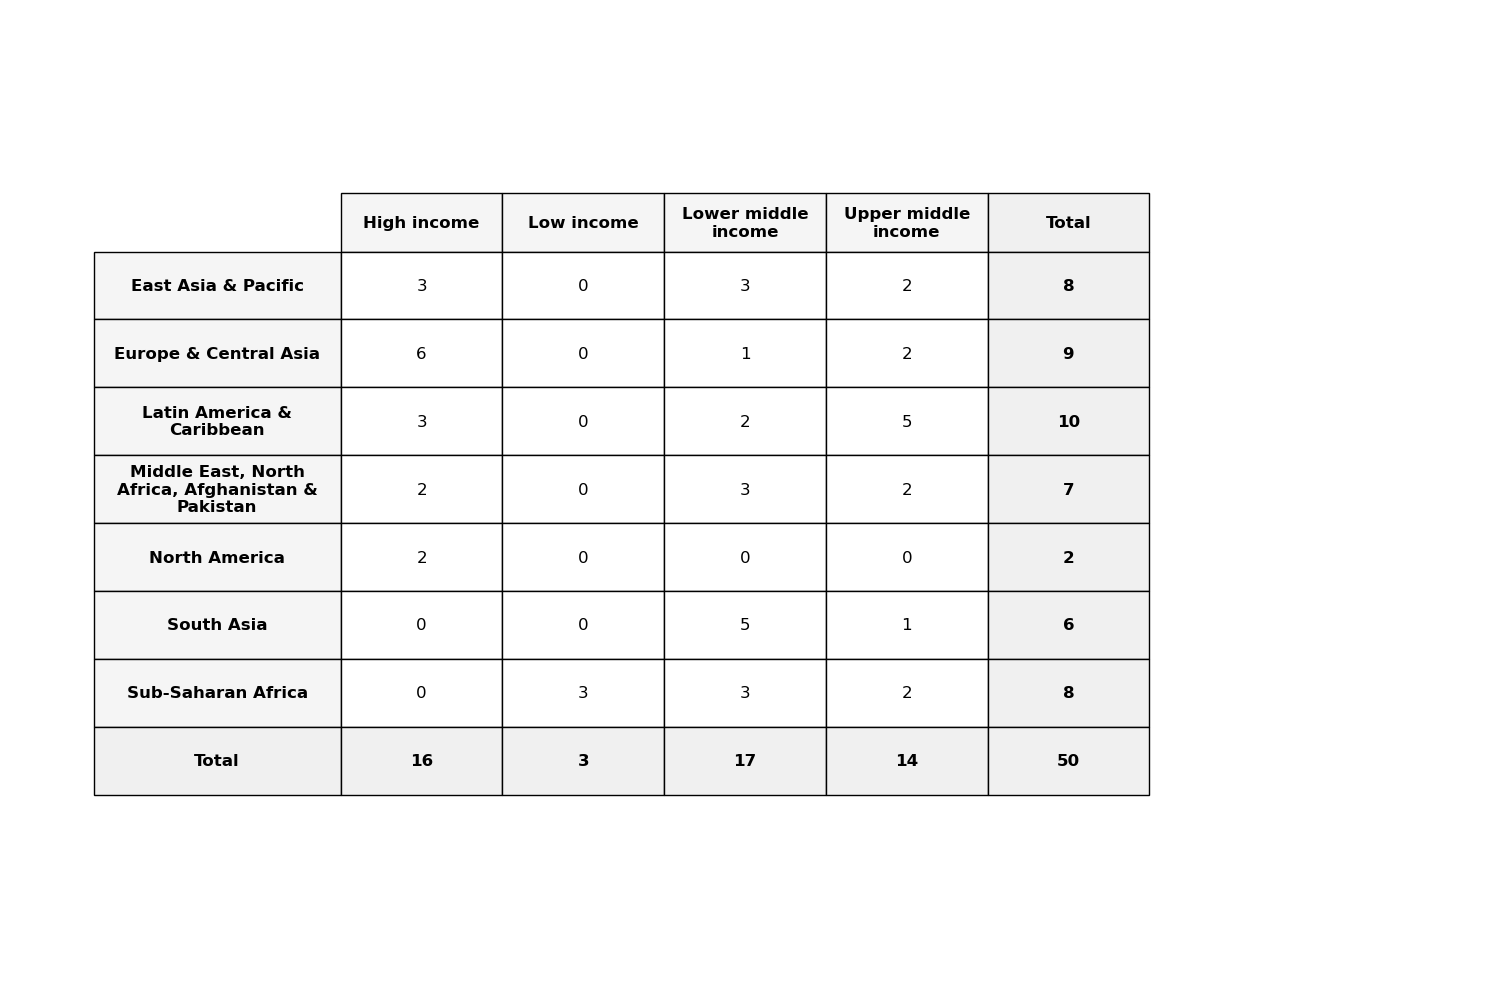

'sustainability-economic-performance/results/country_distribution/region_income_table_50.pdf'

In [22]:
# --- Use matplotlib to convert this table to a pdf ---

import matplotlib.pyplot as plt
import textwrap

df = region_income_50_table.copy()
n_rows, n_cols = df.shape

# --- Wrap long labels ---

def wrap_text(text, width):
    """Insert line breaks every `width` characters (on nearest space)."""
    return "\n".join(textwrap.wrap(str(text), width=width))

# Wrap long region names (row index)
wrapped_index = [wrap_text(idx, width=23) for idx in df.index]

# Wrap long column headers (income groups)
wrapped_columns = [wrap_text(col, width=12) for col in df.columns]

# create the figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis("off")

# build the table
tbl = ax.table(
    cellText=df.values,
    rowLabels=wrapped_index,      # regions + "Total"
    colLabels=wrapped_columns,    # income groups + "Total"
    cellLoc="center",
    rowLoc="center",
    loc="center",
    colWidths=[0.11] + [0.11] * (n_cols - 1),  # first col + others
)

# adjust cell heights
for (row, col), cell in tbl.get_celld().items():
    if row == 0:        # header row
        cell.set_height(0.06)
    else:               # body rows
        cell.set_height(0.07)

# 3. font size
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

# 4. style cells
for (row, col), cell in tbl.get_celld().items():
    # borders
    cell.set_edgecolor("black")
    cell.set_linewidth(1)

    # header row (income groups)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f5f5f5")

    # row labels (regions + "Total") live in column -1 in matplotlib's table
    if col == -1:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f5f5f5")

    # total column OR Total row in bold + light grey
    if col == n_cols - 1 or row == n_rows:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f0f0f0")

plt.tight_layout()

# save to PDF under results/country_distribution
output_path = "sustainability-economic-performance/results/country_distribution/region_income_table_50.pdf"
plt.savefig(output_path, bbox_inches="tight")
plt.show()

output_path

In [25]:
# save the final 50-country dataset
output_path = "sustainability-economic-performance/data/processed/panel_50_countries.csv"
panel_50.to_csv(output_path, index=False)

print("Saved to:", output_path)

Saved to: sustainability-economic-performance/data/processed/panel_50_countries.csv
